In [1]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


# Importing

In [2]:
#Importing all the required modules

import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import sys
print(sys.path)

['', '/usr/local/lib/python3.5/dist-packages/py_translate-1.0.3-py3.5.egg', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/donglee/.local/lib/python3.5/site-packages', '/usr/local/lib/python3.5/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.5/dist-packages/IPython/extensions', '/home/donglee/.ipython']


In [4]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

### Data Reading

In [5]:
root_dir = os.path.abspath('../')
data_dir = os.path.join(root_dir, 'data')



# check for existence
os.path.exists(root_dir)
os.path.exists(data_dir)


True

In [6]:
train = pd.read_csv(os.path.join(data_dir, 'Train', 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'Test.csv'))

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


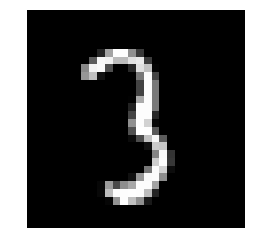

In [7]:
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)

img = imread(filepath, flatten=True)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [8]:
img

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

In [9]:
temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

temp = []
for img_name in test.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
test_x = np.stack(temp)

Let’s take a split size of 70:30 for train set vs validation set

In [10]:
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train.label.values[:split_size], train.label.values[split_size:]

### Helper Functions

Let us create some helper functions which we use later in the code

In [11]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    
    return temp_batch

def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, input_num_units)
    batch_x = preproc(batch_x)
    
    if dataset_name == 'train':
        batch_y = eval(dataset_name).ix[batch_mask, 'label'].values
        batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y

# Model Creation

Let us define a neural network with 3 layers;  input, hidden and output. The number of neurons in input and output are fixed, as the input is our 28 x 28 image and the output is a 10 x 1 vector representing the class. 500 neurons are considered in the hidden layer. This number can vary according to your need.

In [12]:
### set all variables

# number of neurons in each layer
input_num_units = 28*28
hidden_num_units = 500
output_num_units = 10

# define placeholders
x = tf.placeholder(tf.float32, [None, input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])

# set remaining variables
epochs = 5
batch_size = 128
learning_rate = 0.01

### define weights and biases of the neural network

weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units], seed=seed))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed=seed))
}

In [13]:
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)

output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

In [14]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=y))

In [15]:
#Back Propogation: Variant of gradient descent algorithm
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [16]:
#Initialising all the variables
#init = tf.initialize_all_variables()
init = tf.global_variables_initializer()

## Session Creation

In [17]:
with tf.Session() as tfsess:
    tfsess.run(init)
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
            _, c = tfsess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            avg_cost += c / total_batch
        print("Epoch:", (epoch+1), "cost =", "{:.5f}".format(avg_cost))        
    print("\n Training Finished!")
              
    pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    print("Validation Accuracy:", accuracy.eval({x: val_x.reshape(-1, input_num_units), y: dense_to_one_hot(val_y)}))
          
    predict = tf.argmax(output_layer, 1)
    pred = predict.eval({x: test_x.reshape(-1, input_num_units)})

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Epoch: 1 cost = 8.98526
Epoch: 2 cost = 1.76645
Epoch: 3 cost = 0.89633
Epoch: 4 cost = 0.63402
Epoch: 5 cost = 0.44316

 Training Finished!
Validation Accuracy: 0.9539456


# Testing

Prediction is:  4


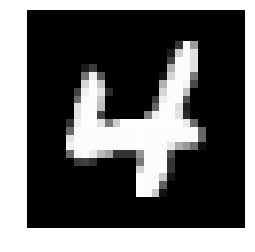

In [18]:
#img_name = rng.choice(test.filename)
img_name = "49102.png"
filepath = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)

img = imread(filepath, flatten=True)

test_index = int(img_name.split('.')[0]) - 49000

print("Prediction is: ", pred[test_index])

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()